In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
simple_transform=transforms.Compose([transforms.ToTensor()])
exp_dataset=datasets.CIFAR10('./data',train=True,download=True,transform=simple_transform)

Files already downloaded and verified


In [3]:
train_loader = torch.utils.data.DataLoader(exp_dataset, batch_size=len(exp_dataset), shuffle=False)
data = next(iter(train_loader))

# Calculate mean and std per channel
mean = data[0].mean(dim=(0, 2, 3))  # Calculate mean across all images and height, width dimensions
std = data[0].std(dim=(0, 2, 3))    # Calculate std across all images and height, width dimensions

print("Mean per channel:", mean)
print("Std per channel:", std)

Mean per channel: tensor([0.4914, 0.4822, 0.4465])
Std per channel: tensor([0.2470, 0.2435, 0.2616])


In [4]:
import cv2
import torchvision

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label
train_transform=A.Compose([
                            A.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
                            A.RandomCrop (32, 32, always_apply=False, p=4),
                            A.HorizontalFlip(0.5),
                           A.CoarseDropout(max_holes = 1, max_height=8, max_width=8, min_holes = 1, min_height=8, min_width=8, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value=None),
                            ToTensorV2()
                           
                                   ])
test_transform=A.Compose([A.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
                          ToTensorV2()
                                   ])
train_data=Cifar10SearchDataset('./data',train=True,download=True,transform=train_transform)
test_data=Cifar10SearchDataset('./data',train=False,download=True,transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? False


In [6]:
from model import Net
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 

/Users/yeswanth/anaconda3/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
 84%|███████████████████████████████████▎      | 84/100 [00:11<00:02,  7.46it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.68E-02


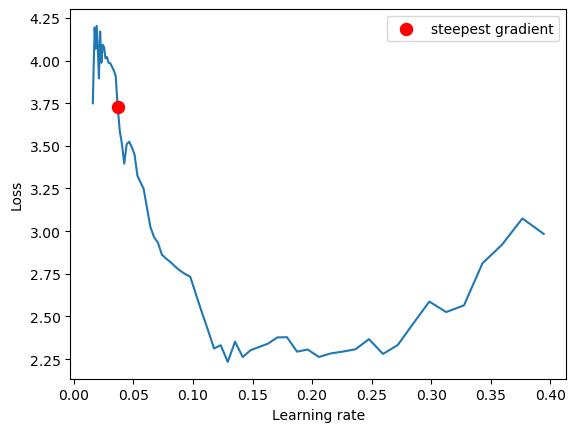

In [7]:
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="mps")
lr_finder.range_test(train_loader,end_lr=1, num_iter=100, step_mode="exp")
lr_finder.plot(log_lr=False)
lr_finder.reset()

In [8]:
total_steps=512
epochs=24
from train import train,test
device = torch.device("mps")
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01,weight_decay=1e-7)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0368,epochs=24,total_steps=len(train_loader)*epochs,div_factor=10,final_div_factor=10)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
for epoch in range(1, 25):
    print(epoch)
    train_loss,train_accuracy=train(model, device, train_loader, optimizer, scheduler,epoch)
    test_loss,test_accuracy=test(model, device, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

1


loss=1.150476098060608 batch_id=781 Accuracy=41.92: 100%|█| 782/782 [01:42<00:00



Test set: Average loss: 1.3622, Accuracy: 5466/10000 (55%)

2


loss=1.1159662008285522 batch_id=781 Accuracy=67.25: 100%|█| 782/782 [01:38<00:0



Test set: Average loss: 0.8432, Accuracy: 7222/10000 (72%)

3


loss=0.6900853514671326 batch_id=781 Accuracy=74.25: 100%|█| 782/782 [01:39<00:0



Test set: Average loss: 0.8073, Accuracy: 7246/10000 (72%)

4


loss=0.8198038935661316 batch_id=781 Accuracy=75.99: 100%|█| 782/782 [01:38<00:0



Test set: Average loss: 1.0585, Accuracy: 6836/10000 (68%)

5


loss=1.6107653379440308 batch_id=781 Accuracy=75.53: 100%|█| 782/782 [01:40<00:0



Test set: Average loss: 1.0632, Accuracy: 6992/10000 (70%)

6


loss=0.7773193120956421 batch_id=781 Accuracy=75.77: 100%|█| 782/782 [01:39<00:0



Test set: Average loss: 0.8873, Accuracy: 7218/10000 (72%)

7


loss=0.23471561074256897 batch_id=781 Accuracy=76.41: 100%|█| 782/782 [01:39<00:



Test set: Average loss: 0.7355, Accuracy: 7637/10000 (76%)

8


loss=0.6294552087783813 batch_id=781 Accuracy=78.10: 100%|█| 782/782 [01:47<00:0



Test set: Average loss: 0.7988, Accuracy: 7387/10000 (74%)

9


loss=0.6162096261978149 batch_id=781 Accuracy=79.50: 100%|█| 782/782 [01:50<00:0



Test set: Average loss: 0.7057, Accuracy: 7638/10000 (76%)

10


loss=0.546355128288269 batch_id=781 Accuracy=80.61: 100%|█| 782/782 [01:54<00:00



Test set: Average loss: 0.6331, Accuracy: 8009/10000 (80%)

11


loss=0.13497884571552277 batch_id=781 Accuracy=83.01: 100%|█| 782/782 [01:53<00:



Test set: Average loss: 0.6934, Accuracy: 7898/10000 (79%)

12


loss=1.2856777906417847 batch_id=781 Accuracy=84.33: 100%|█| 782/782 [01:47<00:0



Test set: Average loss: 0.7051, Accuracy: 7929/10000 (79%)

13


loss=0.6828190088272095 batch_id=781 Accuracy=86.37: 100%|█| 782/782 [01:45<00:0



Test set: Average loss: 0.6480, Accuracy: 8159/10000 (82%)

14


loss=0.09108766913414001 batch_id=781 Accuracy=87.68: 100%|█| 782/782 [01:52<00:



Test set: Average loss: 0.5366, Accuracy: 8296/10000 (83%)

15


loss=0.22058948874473572 batch_id=781 Accuracy=89.95: 100%|█| 782/782 [01:45<00:



Test set: Average loss: 0.5682, Accuracy: 8382/10000 (84%)

16


loss=0.2186683714389801 batch_id=781 Accuracy=91.71: 100%|█| 782/782 [01:48<00:0



Test set: Average loss: 0.6131, Accuracy: 8367/10000 (84%)

17


loss=0.01597379706799984 batch_id=781 Accuracy=93.67: 100%|█| 782/782 [01:51<00:



Test set: Average loss: 0.5863, Accuracy: 8461/10000 (85%)

18


loss=0.057969462126493454 batch_id=781 Accuracy=95.00: 100%|█| 782/782 [02:00<00



Test set: Average loss: 0.6032, Accuracy: 8554/10000 (86%)

19


loss=0.36232754588127136 batch_id=781 Accuracy=96.47: 100%|█| 782/782 [01:51<00:



Test set: Average loss: 0.5953, Accuracy: 8603/10000 (86%)

20


loss=0.09435243904590607 batch_id=781 Accuracy=97.30: 100%|█| 782/782 [01:51<00:



Test set: Average loss: 0.7448, Accuracy: 8479/10000 (85%)

21


loss=0.07719388604164124 batch_id=781 Accuracy=98.19: 100%|█| 782/782 [01:52<00:



Test set: Average loss: 0.6152, Accuracy: 8656/10000 (87%)

22


loss=0.0028192135505378246 batch_id=781 Accuracy=98.45: 100%|█| 782/782 [01:50<0



Test set: Average loss: 0.6340, Accuracy: 8651/10000 (87%)

23


loss=0.21023762226104736 batch_id=781 Accuracy=98.72: 100%|█| 782/782 [02:14<00:



Test set: Average loss: 0.6274, Accuracy: 8669/10000 (87%)

24


loss=0.014528946951031685 batch_id=781 Accuracy=98.83: 100%|█| 782/782 [02:31<00



Test set: Average loss: 0.6126, Accuracy: 8686/10000 (87%)

